# Baseline Model

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, PrecisionRecallDisplay, RocCurveDisplay
)

c:\Users\brt.rtawil\Documents\EY\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
acc_sub = pd.read_csv('../eda/lc_accepted_outputs/accepted_subset_clean.csv')

## Prepare features & split (same target, balanced class weights)

In [4]:
target = "default_flag"

model_feats = [c for c in [
    "loan_amnt","int_rate","fico_range_low","fico_range_high",
    "annual_inc","dti","revol_util","emp_length_num","term_num",
    "grade","sub_grade","home_ownership","verification_status","purpose"
] if c in acc_sub.columns]

num_cols = [c for c in ["loan_amnt","int_rate","fico_range_low","fico_range_high","annual_inc","dti","revol_util","emp_length_num","term_num"] if c in model_feats]
cat_cols = [c for c in ["grade","sub_grade","home_ownership","verification_status","purpose"] if c in model_feats]

X = acc_sub[model_feats].copy()
y = acc_sub[target].astype(int)

# Simple imputations
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
for c in cat_cols:
    X[c] = X[c].astype("object").fillna("Unknown")

pre = ColumnTransformer([
    ("num","passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## Train the Decision Tree (interpretable, class imbalance-aware)

In [5]:
tree = Pipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(
        max_depth=5,            # interpretable depth
        min_samples_leaf=200,   # regularization + stability
        class_weight="balanced",
        random_state=42
    ))
])

tree.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluate with rare-event metrics + curves

{'ROC_AUC': 0.6967, 'PR_AUC': 0.132, 'Precision@0.5': 0.1075, 'Recall@0.5': 0.6997, 'F1@0.5': 0.1864, 'Base rate (defaults)': np.float64(0.0687)}

Confusion matrix @0.5:
 [[6651 4990]
 [ 258  601]]

Classification report @0.5:
               precision    recall  f1-score   support

           0      0.963     0.571     0.717     11641
           1      0.107     0.700     0.186       859

    accuracy                          0.580     12500
   macro avg      0.535     0.635     0.452     12500
weighted avg      0.904     0.580     0.681     12500



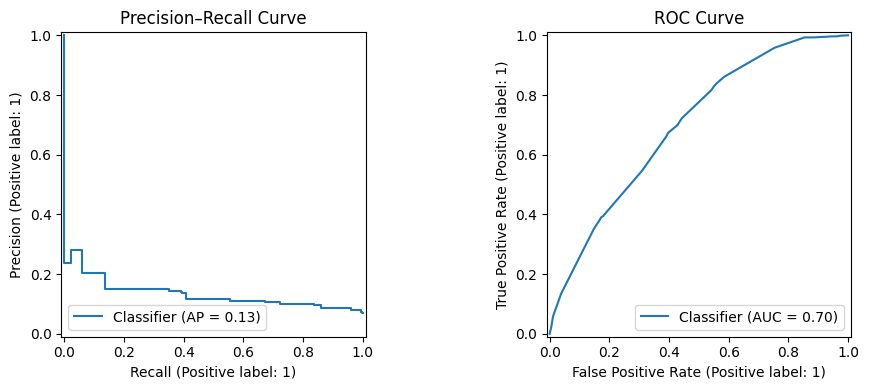

In [6]:
# Probabilities & default threshold (0.5). We'll also show threshold-at-K later.
p_test = tree.predict_proba(X_test)[:, 1]
y_pred_05 = (p_test >= 0.5).astype(int)

# Core rare-event metrics
roc_auc = roc_auc_score(y_test, p_test)
pr_auc  = average_precision_score(y_test, p_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_05, average="binary", zero_division=0)

print({
    "ROC_AUC": round(roc_auc, 4),
    "PR_AUC": round(pr_auc, 4),
    "Precision@0.5": round(precision, 4),
    "Recall@0.5": round(recall, 4),
    "F1@0.5": round(f1, 4),
    "Base rate (defaults)": round(y_test.mean(), 4),
})

print("\nConfusion matrix @0.5:\n", confusion_matrix(y_test, y_pred_05))
print("\nClassification report @0.5:\n", classification_report(y_test, y_pred_05, digits=3))

# Curves
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
PrecisionRecallDisplay.from_predictions(y_test, p_test, ax=ax1)
ax1.set_title("Precision–Recall Curve")

ax2 = plt.subplot(1,2,2)
RocCurveDisplay.from_predictions(y_test, p_test, ax=ax2)
ax2.set_title("ROC Curve")
plt.tight_layout(); plt.show()


* **Imbalance:** Base default rate ≈ **6.9%** (859/12,500). So most loans don’t default.
* **Discrimination power:**

  * **ROC AUC = 0.697** → modest ability to rank-risk above random (0.5) but far from strong (>0.80).
  * **PR AUC = 0.132** vs **baseline = 0.069** (the base rate). That’s a **modest lift** in the regime that matters (rare positives), but still not great.
* **At the 0.5 threshold (current operating point):**

  * **Recall (defaults caught)** = **0.70** → it find ~70% of true defaulters (601/859).
  * **Precision** = **0.108** → only ~11% of flagged applicants actually default. **~89% are false alarms.**
  * **Accuracy** = **0.58** (not meaningful under imbalance).
  * **Specificity** = **0.571** → **FPR ≈ 43%** (4,990/11,641 good borrowers are mis-flagged).
  * **NPV ≈ 96.3%** → when it *doesn’t* flag, it is almost always right.

**Confusion matrix @0.5**

* TN = 6,651
* FP = 4,990
* FN = 258
* TP = 601

**Business translation**
IT reject **5,591** applicants, of which only **601 (10.8%)** would have defaulted; **4,990 (89.2%)** are good customers you’d lose.


### Threshold-at-K (operational cutoffs for underwriting)

In [7]:
def threshold_at_k_report_tieaware(probs, y_true, k_list=[0.05, 0.10, 0.20]):

    idx = np.argsort(-probs, kind="mergesort")  # stable
    reports = {}
    n = len(probs)
    for k in k_list:
        kcount = max(1, int(round(k * n)))
        sel_idx = idx[:kcount]

        # If many ties at the boundary, slice exactly kcount; that’s deterministic & fair.
        y_hat = np.zeros(n, dtype=int)
        y_hat[sel_idx] = 1

        cm = confusion_matrix(y_true, y_hat)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        thr = probs[sel_idx[-1]]  # last selected score

        reports[f"top_{int(k*100)}pct"] = {
            "threshold": float(thr),
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
            "confusion_matrix": cm.tolist(),
        }
    return reports


In [8]:
reports = threshold_at_k_report_tieaware(p_test, y_test, k_list=[0.05, 0.10, 0.20])
reports

{'top_5pct': {'threshold': 0.6645270955957193,
  'precision': 0.1984,
  'recall': 0.14435389988358557,
  'f1': 0.16711590296495957,
  'confusion_matrix': [[11140, 501], [735, 124]]},
 'top_10pct': {'threshold': 0.6645270955957193,
  'precision': 0.1616,
  'recall': 0.2351571594877765,
  'f1': 0.19155998103366526,
  'confusion_matrix': [[10593, 1048], [657, 202]]},
 'top_20pct': {'threshold': 0.6173223395117136,
  'precision': 0.1388,
  'recall': 0.4039580908032596,
  'f1': 0.20660910985412326,
  'confusion_matrix': [[9488, 2153], [512, 347]]}}

**Top 5% flagged (625 cases)**

* Threshold ≈ **0.6645** (same as 10% → heavy ties near the cut).
* **Precision 19.84%** → ~**2.9×** base rate.
* **Recall 14.44%** → catches **124/859** defaulters.
* Confusion: TN 11,140 | **FP 501** | **FN 735** | **TP 124**.
* **FPR ≈ 4.3%** (501/11,641). Small review queue, best hit-rate.

**Top 10% flagged (1,250 cases)**

* Threshold ≈ **0.6645** (ties again).
* **Precision 16.16%** → ~**2.35×** base.
* **Recall 23.52%** → **202/859** defaulters caught.
* Confusion: TN 10,593 | **FP 1,048** | **FN 657** | **TP 202**.
* **FPR ≈ 9.0%**. ~2× workload vs 5%, +78 more TP, precision dips modestly.

**Top 20% flagged (2,500 cases)**

* Threshold ≈ **0.6173** (lower cut).
* **Precision 13.88%** → ~**2.0×** base.
* **Recall 40.40%** → **347/859** defaulters caught.
* Confusion: TN 9,488 | **FP 2,153** | **FN 512** | **TP 347**.
* **FPR ≈ 18.5%**. Big workload, more catch, hit-rate falls.

### What this means

* It have a **nice precision–recall curve**: as it review more, it catch more defaults, but the **marginal precision drops**.
* **Efficiency (lift over base):** 5% (2.9×) > 10% (2.35×) > 20% (2.0×).
* **Capacity choice:**

  * **Tight ops / high precision needed:** pick **5%**.
  * **Balanced:** **10%** doubles the queue for +63% more defaults caught (124 → 202).
  * **Aggressive recall:** **20%**, but expect many more false alarms.

### Business rule of thumb (reject vs. review)

If we **reject** flagged loans outright, require precision ≥ ( \frac{P}{P+L} ), where:

* (L) = expected loss if a defaulted loan were approved,
* (P) = profit from a performing loan.
  Example: if (L = $5,000) and (P = $500), breakeven precision = (500/(500+5000) \approx 9.1%). All three cuts clear that, but higher precision means more margin.

If we **manual-review** flagged loans, the question is **review capacity** and **cost per review**. Compute EV per reviewed case:
[
\text{EV} = \text{precision}\cdot L_\text{avoided} - (1-\text{precision})\cdot C_\text{review}
]
and pick k that maximizes total EV under capacity constraints.

### Recommendation

* Choose **k by capacity/economics**: start at **10%** if you can review ~1,250 cases; otherwise **5%** for a lean, high-yield queue. Move toward **20%** only if the incremental catch justifies the extra false positives.
* Next, **calibrate probabilities** and re-run top-k: you’ll often gain a couple precision points at the same recall, especially near these cutoffs.
* Track a **top-k sweep** (1%, 2%, 5%, 10%, 15%, 20%) with precision, recall, and approvals lost—this makes the policy choice straightforward.


## Feature Importance

In [9]:
# Get feature names after OneHot
ohe = tree.named_steps["pre"].transformers_[1][1]
cat_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feature_names = num_cols + cat_names

importances = tree.named_steps["clf"].feature_importances_
imp = (pd.Series(importances, index=feature_names)
         .sort_values(ascending=False)
         .head(25))
imp


int_rate                        0.790518
grade_A                         0.100425
sub_grade_B4                    0.022253
loan_amnt                       0.020073
sub_grade_C3                    0.016764
home_ownership_MORTGAGE         0.012162
fico_range_high                 0.011767
revol_util                      0.011648
emp_length_num                  0.006394
grade_E                         0.005545
annual_inc                      0.001788
verification_status_Verified    0.000663
dti                             0.000000
fico_range_low                  0.000000
grade_F                         0.000000
grade_G                         0.000000
sub_grade_A1                    0.000000
sub_grade_A2                    0.000000
sub_grade_A3                    0.000000
sub_grade_A4                    0.000000
term_num                        0.000000
grade_B                         0.000000
sub_grade_B1                    0.000000
sub_grade_A5                    0.000000
sub_grade_B3    

The values represent the relative contribution of each feature to the model's predictive power.

### Key Takeaways

1.  **Dominant Feature:** The model is overwhelmingly driven by the **interest rate (`int_rate`)**.
2.  **Importance of Creditworthiness:** Loan **grade** and **sub\_grade** features (e.g., `grade_A`, `sub_grade_B4`) are the next most important, indicating that credit quality is a significant factor.
3.  **Feature Selection:** The features with $0.00$ importance are candidates for **removal** as they are not adding predictive value to the model.


# Save the model

In [ ]:
OUTDIR = Path("./saved_models")
model_path = OUTDIR / f"baseline.joblib"
joblib.dump(tree, model_path)

meta = {
    "selected": 'Baseline',
    "report": reports,
    "feature_set": model_feats,
    "numeric_columns": num_cols,
    "categorical_columns": cat_cols,
}
with open(OUTDIR / "baseline.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"\nSaved best model to: {model_path}")
print(f"Saved metadata to:   {OUTDIR / 'baseline.json'}")


Saved best model to: saved_models\baseline.joblib
Saved metadata to:   saved_models\baseline.json


### Test the model with an example

In [ ]:
example = pd.DataFrame([{
    "loan_amnt": 10000,
    "int_rate": 13.56,
    "fico_range_low": 660,
    "fico_range_high": 664,
    "annual_inc": 55000,
    "dti": 18.0,
    "revol_util": 57.1,
    "emp_length_num": 5,
    "term_num": 36,
    "grade": "B",
    "sub_grade": "B3",
    "home_ownership": "MORTGAGE",
    "verification_status": "Source Verified",
    "purpose": "debt_consolidation"
}])
example_pred = tree.predict_proba(example)[:, 1][0]
print(f"\nExample prediction (probability of default): {example_pred:.4f}") 


Example prediction (probability of default): 0.5792
